In [68]:
from dataclasses import dataclass
import subprocess
import os
from typing import Tuple
import pandas as pd
import re
import matplotlib.pyplot as plt


@dataclass
class PlotData:
    num_elements: int
    radius: int
    cpu_omp_time: float
    cpu_fast_time: float
    gpu_time: float

In [69]:
TOTAL_GPU_RE = re.compile(r"Total GPU execution time:\s*(\d+.\d+) ms\n")
TOTAL_CPU_RE = re.compile(r"CPU execution time:\s*(\d+.\d+) ms\n")
TOTAL_CPU_FAST_RE = re.compile(r"CPU FAST execution time:\s*(\d+.\d+) ms\n")


def run_benchmark(num_elements: int, radius: int) -> PlotData:
    print(f"Running benchmark for {num_elements} elements and radius {radius}")
    exec_name = f"solution__{num_elements}__{radius}"
    cuda_name = f"solution.cu"
    !nvcc -o {exec_name} {cuda_name} -DNUM_ELEMENTS={num_elements} -DRADIUS={radius} -Xcompiler -fopenmp
    output = subprocess.check_output([f"./{exec_name}"]).decode("utf-8")
    gpu_time = float(TOTAL_GPU_RE.search(output).group(1))
    cpu_omp_time = float(TOTAL_CPU_RE.search(output).group(1))
    cpu_fast_time = float(TOTAL_CPU_FAST_RE.search(output).group(1))
    return PlotData(num_elements, radius, cpu_omp_time, cpu_fast_time, gpu_time)

In [70]:
NUM_ELEMENTS = map(int, [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 9e8])
RADIUS = [3, 30, 300, 3000]

results = [
    run_benchmark(num_elements, radius)
    for num_elements in NUM_ELEMENTS
    for radius in RADIUS
]

Running benchmark for 1000 elements and radius 3


Running benchmark for 1000 elements and radius 30
Running benchmark for 1000 elements and radius 300
Running benchmark for 1000 elements and radius 3000
Running benchmark for 10000 elements and radius 3
Running benchmark for 10000 elements and radius 30
Running benchmark for 10000 elements and radius 300
Running benchmark for 10000 elements and radius 3000
Running benchmark for 100000 elements and radius 3
Running benchmark for 100000 elements and radius 30
Running benchmark for 100000 elements and radius 300
Running benchmark for 100000 elements and radius 3000
Running benchmark for 1000000 elements and radius 3
Running benchmark for 1000000 elements and radius 30
Running benchmark for 1000000 elements and radius 300
Running benchmark for 1000000 elements and radius 3000
Running benchmark for 10000000 elements and radius 3
Running benchmark for 10000000 elements and radius 30
Running benchmark for 10000000 elements and radius 300
Running benchmark for 10000000 elements and radius 3000

In [71]:
!rm solution__*

In [72]:
df = pd.DataFrame(results)
df

,num_elements,radius,cpu_omp_time,cpu_fast_time,gpu_time
0,1000,3,143.8,0.0,0.4
1,1000,30,146.7,0.0,0.6
2,1000,300,101.2,0.0,0.4
3,1000,3000,1.6,0.0,0.7
4,10000,3,0.3,0.0,0.2
5,10000,30,138.6,0.0,0.1
6,10000,300,141.4,0.0,0.5
7,10000,3000,153.7,0.0,0.5
8,100000,3,0.4,7.1,0.4
9,100000,30,83.0,1.2,0.5


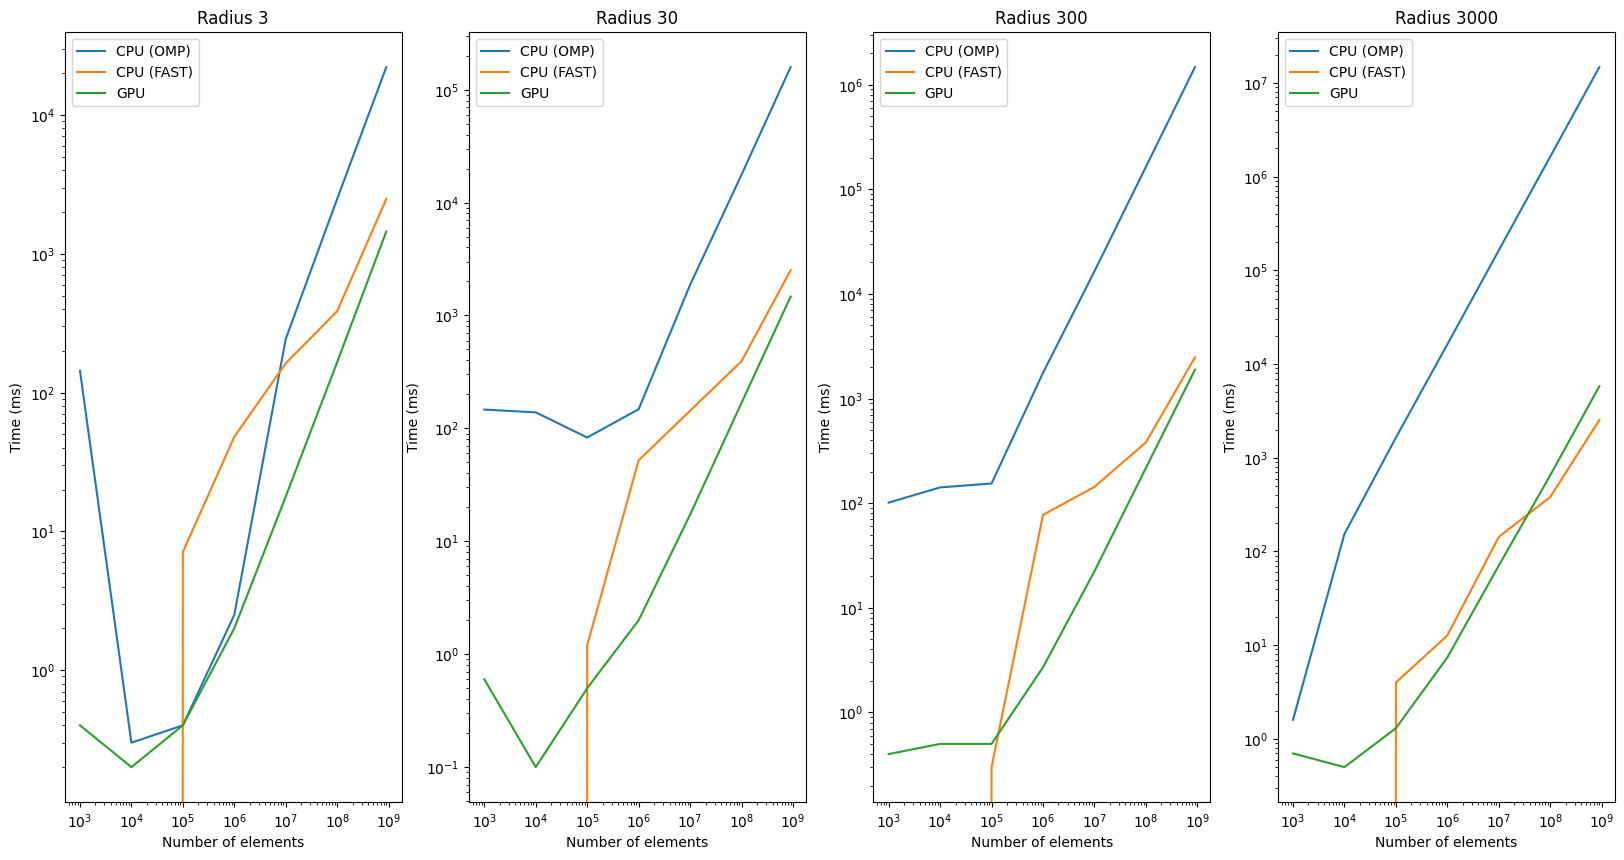

In [73]:
fig, axs = plt.subplots(1, len(RADIUS), figsize=(20, 10))

for i, radius in enumerate(RADIUS):
    sub_df = df[df.radius == radius]
    axs[i].plot(sub_df.num_elements, sub_df.cpu_omp_time, label="CPU (OMP)")
    axs[i].plot(sub_df.num_elements, sub_df.cpu_fast_time, label="CPU (FAST)")
    axs[i].plot(sub_df.num_elements, sub_df.gpu_time, label="GPU")
    axs[i].set_title(f"Radius {radius}")
    axs[i].set_xlabel("Number of elements")
    axs[i].set_ylabel("Time (ms)")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].legend()

fig.savefig("benchmark.png")


In [74]:
df

,num_elements,radius,cpu_omp_time,cpu_fast_time,gpu_time
0,1000,3,143.8,0.0,0.4
1,1000,30,146.7,0.0,0.6
2,1000,300,101.2,0.0,0.4
3,1000,3000,1.6,0.0,0.7
4,10000,3,0.3,0.0,0.2
5,10000,30,138.6,0.0,0.1
6,10000,300,141.4,0.0,0.5
7,10000,3000,153.7,0.0,0.5
8,100000,3,0.4,7.1,0.4
9,100000,30,83.0,1.2,0.5
